## Import required Python modules

## Download data and pre-proces data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# NPZ files path
data_path='/home/sandeep/storage/extracted_data/test'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

data_file = '/Test_Data_5698.npz'
data=np.load(data_path+data_file)

In [4]:
X = np.float32(np.dstack((np.float32(data['arr_9']), np.float32(data['arr_10']), np.float32(data['arr_11']),
                          np.float32(data['arr_12']), np.float32(data['arr_13']), np.float32(data['arr_14']),
                         np.float32(data['arr_15']), np.float32(data['arr_16']), np.float32(data['arr_17']),
                         np.float32(data['arr_18']), np.float32(data['arr_19']))))
#X = np.float32(X)
#Y = np.int8(Y)
print(X.shape)


(5698, 6000, 11)


In [5]:
print(X.nbytes)


1504272000


In [6]:
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.shape[0]-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L,a.shape[1] ), strides=(S*n,n,a.strides[1]))

In [7]:
X2 = []
for i in range (0, X.shape[0]):
    X2.append(strided_app(X[i],500,250))
    
X2 = np.asarray(X2)
X2 = X2.reshape((-1,500,11))
del X

## Load the pre-processed data

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Bidirectional, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint

/home/sandeep/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
z = 0
z1 = 0
X_train0 = X2[:z]
X_val0 = X2[z:z1]
X_test0 = X2[z1:]
print(np.shape(X_train0))
print(np.shape(X_val0))
print(np.shape(X_test0))


(0, 500, 11)
(0, 500, 11)
(131054, 500, 11)


## My Models

In [10]:
def _data_reshaping(X_tr, X_va, X_ts, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
        X_ts = np.swapaxes(X_ts,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_ts = np.reshape(X_ts, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
        X_ts = np.reshape(X_ts, (-1, dim*win_len))
    
    return X_tr, X_va, X_ts

In [11]:
def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(Bidirectional(LSTM(32, return_sequences=True, stateful=False)))
        #model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization()) #added
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp,p):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [12]:
batch_size = 512
num_feat_map = 64
num_hidden_mlp = 128
num_hidden_lstm = 64
num_classes = 8

#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_val, X_test = _data_reshaping(X_train0, X_val0, X_test0, network_type)

500
11
ConvLSTM


In [23]:
p=0.3 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp,p) 
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 11, 500, 64)       384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 500, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 250, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 250, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 250, 64)       12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 250, 64)       256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 125

In [51]:
epochs = 20
batch_size = 512

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath="weights_best_timd.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, Y_val),
             callbacks=callbacks_list)

Train on 280002 samples, validate on 39997 samples
Epoch 1/20
280002/280002 [==============================] - 283s 1ms/step - loss: 0.2496 - acc: 0.9141 - val_loss: 0.3329 - val_acc: 0.8913

Epoch 00001: val_acc improved from -inf to 0.89132, saving model to weights_best_timd.hdf5
Epoch 2/20
280002/280002 [==============================] - 281s 1ms/step - loss: 0.2525 - acc: 0.9129 - val_loss: 0.7202 - val_acc: 0.7834

Epoch 00002: val_acc did not improve
Epoch 3/20
280002/280002 [==============================] - 282s 1ms/step - loss: 0.2414 - acc: 0.9172 - val_loss: 0.3529 - val_acc: 0.8837

Epoch 00003: val_acc did not improve
Epoch 4/20
280002/280002 [==============================] - 282s 1ms/step - loss: 0.2417 - acc: 0.9169 - val_loss: 0.5293 - val_acc: 0.8369

Epoch 00004: val_acc did not improve
Epoch 5/20
280002/280002 [==============================] - 282s 1ms/step - loss: 0.2347 - acc: 0.9194 - val_loss: 0.3517 - val_acc: 0.8880

Epoch 00005: val_acc did not improve
Epoch

In [13]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
model = load_model('Conv_lstm_timd_94')
#model = load_model('Conv_lstm_mag')

In [16]:
y_pred = np.argmax(model.predict(X_test), axis=2)
print(y_pred.shape)


(131054, 125)


In [17]:
y_pred3 = y_pred.reshape(-1)

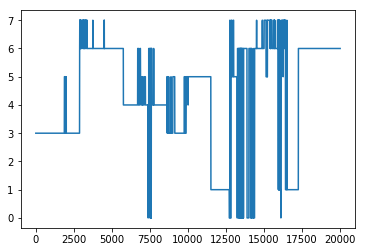

In [18]:
plt.figure()
plt.plot(y_pred3[:20000])
plt.show()

In [19]:
y_pred2 = np.zeros((int(len(y_pred3)/125)))
ind = 0
for i in range (0,len(y_pred3), 125):
    (values,counts) = np.unique(y_pred3[i:i+125],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
    ind = ind+1
print(y_pred2.shape)


(131054,)


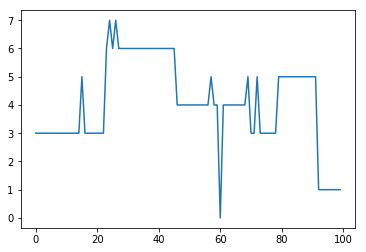

In [20]:
plt.figure()
plt.plot(y_pred2[:100])
plt.show()

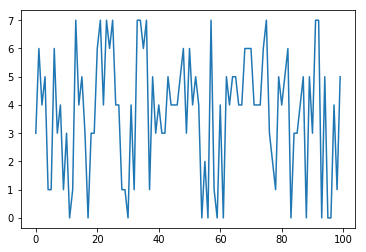

In [21]:
y_pred4 = np.zeros((int(len(y_pred2)/23)))
ind = 0
for i in range (0,len(y_pred2), 23):
    (values,counts) = np.unique(y_pred2[i:i+23],return_counts=True)
    c = np.argmax(counts)
    y_pred4[ind] = values[c]
    ind = ind+1
    
plt.figure()
plt.plot(y_pred4[:100])
plt.show()



In [22]:
print(y_pred4.shape)
y_pred4 = np.int8(y_pred4) + 1
y_pred4 = y_pred4.repeat(6000).reshape(-1,6000)
print(y_pred4.shape)


out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_60/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='timd_94'
np.save(out_path + out_file, y_pred4)

(5698,)
(5698, 6000)


In [59]:
y_pred4 = y_pred4.reshape(-1)
print(y_pred4.shape)


(14382000,)
(14382000,)
[[1993214   26736    2528   12703    1409    7378   73535   20055]
 [  35682 1739198    4559    7421    1076    1361    6842   10407]
 [      0    1902  587174       0    1324       0       0       0]
 [  11495   17419    2538 1839557     851    3809    6088       0]
 [      0    4019    1037    3971 2226592    6000       0       0]
 [   6311    7878    2164    6000    6748 1715452    1916   17313]
 [  36530    2383       0    2348   12000   12000 1970555   78507]
 [  40768    6465       0       0    6000   54000  215064 1523718]]
the mean-f1 score: 0.948444
accuracy is: 0.945311


In [28]:
y_pred4 = np.zeros((int(len(y_pred2)/23)*2))
ind = 0
for i in range (0,len(y_pred), 23):
    (values,counts) = np.unique(y_pred2[i:i+14],return_counts=True)
    c = np.argmax(counts)
    y_pred4[ind] = values[c]
    
    (values,counts) = np.unique(y_pred2[i+9:i+23],return_counts=True)
    c = np.argmax(counts)
    y_pred4[ind+1] = values[c]
    
    ind = ind+2

In [29]:
print(y_pred4.shape)
y_pred4 = np.int8(y_pred4) + 1
y_pred4 = y_pred4.repeat(3000).reshape(-1,6000)
print(y_pred4.shape)



out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_30/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='timd_94'
np.save(out_path + out_file, y_pred4)

(4794,)
(2397, 6000)
(2397, 6000)


In [30]:
y_true = y_true.reshape(-1)
y_pred4 = y_pred4.reshape(-1)
print(y_true.shape)
print(y_pred4.shape)
cf_matrix = confusion_matrix(y_true, y_pred4)
print(cf_matrix)
class_wise_f1 = f1_score(y_true, y_pred4, average=None)
accuracy = accuracy_score(y_true, y_pred4)

print('the mean-f1 score: {:.6f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.6f}'.format(accuracy))

(14382000,)
(14382000,)
[[2030220   15441    2528    7177    1409    7958   58535   14290]
 [  31444 1748336    4559    2837    1540    1361    3311   13158]
 [   3000    1902  583712     462    1324       0       0       0]
 [  17969   12835       0 1842869    1187     809    5465     623]
 [      0    1483    1037    1307 2234792    3000       0       0]
 [   5834    8935    2164    3000    6748 1720872    1916   14313]
 [  51530    4110       0    2348   18000   24000 1915451   98884]
 [  56003    3958       0       0    6000   63000  220322 1496732]]
the mean-f1 score: 0.946837
accuracy is: 0.943748


In [45]:
y_pred2.shape

(55131,)

In [70]:
model.save('Conv_lstm_timd_94')

In [49]:
print(y_pred2.shape)

(55131,)
